## Install dependencies

In [269]:
!pip install git+https://github.com/LIAAD/yake
!pip install mrakun
!pip install textacy
!pip install git+https://developer.nasa.gov/DataSquad/classifier_scripts.git@v1.0.2#egg=dsconcept
!pip install sparqlwrapper

In [249]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/abuonomo/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [239]:
from SPARQLWrapper import SPARQLWrapper, JSON

queryString = "SELECT * WHERE { ?s ?p ?o. } LIMIT 20"
sparql = SPARQLWrapper("http://vocabs.ands.org.au/repository/api/sparql/aas_the-unified-astronomy-thesaurus_3-1-0")

sparql.setQuery(queryString)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# try:
#     ret = sparql.query()
#    # ret is a stream with the results in XML, see <http://www.w3.org/TR/rdf-sparql-XMLres/>
# except:
#     deal_with_the_exception()

In [43]:
df['text'].iloc[1]

'CHIANTI - an atomic database for emission lines. A comprehensive set of accurate atomic data is required for analyses of astrophysical and solar spectra. CHIANTI provides a database of atomic energy levels, wavelengths, radiative data and electron excitation data for ions which are abundant in cosmic plasmas. The most recent electron excitation data have been assessed and stored following the method of \\cite[Burgess \\&amp; Tully (1992)]{bur92}. The current version is essentially complete for specifying the emission spectrum at wavelengths greater than 50 Angstroms. A list of observed lines in the spectral region between 50 and 1100 Angstroms has been compiled and compared with the lines predicted by the CHIANTI database. The CHIANTI database reproduces the vast majority of lines observed at these wavelengths. CHIANTI includes IDL (Interactive Data Language) routines to calculate optically thin synthetic spectra for equilibrium conditions. IDL routines to calculate theoretical line i

In [240]:
results

{'head': {'vars': ['s', 'p', 'o']},
 'results': {'bindings': [{'p': {'type': 'uri',
     'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'},
    's': {'type': 'uri',
     'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'},
    'o': {'type': 'uri',
     'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#Property'}},
   {'p': {'type': 'uri',
     'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'},
    's': {'type': 'uri',
     'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'},
    'o': {'type': 'uri',
     'value': 'http://www.w3.org/2000/01/rdf-schema#Resource'}},
   {'p': {'type': 'uri',
     'value': 'http://www.w3.org/2000/01/rdf-schema#domain'},
    's': {'type': 'uri',
     'value': 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'},
    'o': {'type': 'uri',
     'value': 'http://www.w3.org/2000/01/rdf-schema#Resource'}},
   {'p': {'type': 'uri',
     'value': 'http://www.w3.org/2000/01/rdf-schema#range'},
    's': {'type': 'uri',
     'value'

# New Main

In [1]:
import sys
sys.path.append('../src')

In [5]:
import feature_topic_model_eval as fe
from tqdm.notebook import tqdm
import dsconcept.model as md
from pathlib import Path
from gensim.utils import tokenize
fe.tqdm = tqdm

In [32]:
import imp; imp.reload(fe)

<module 'feature_topic_model_eval' from '../src/feature_topic_model_eval.py'>

In [7]:
tqdm.pandas()

In [9]:
infile = Path("../data/full_04_01_2020/kwds.jsonl")
df = fe.load_data(infile, size=10_000)
df = df.pipe(fe.get_textrank_kwds).pipe(fe.get_rake_kwds)

04-May-20 11:15:22 - Loading dataframe with shape: (3718, 5)
04-May-20 11:15:22 - Getting textrank keywords


04-May-20 11:17:35 - Getting rake keywords


In [11]:
md.extract_features_from_abstracts(df['text'], 'tmp.jsonl', 100, 12)

04-May-20 11:29:13 - Extracting features to tmp.jsonl
3718it [01:30, 41.30it/s]
04-May-20 11:30:43 - Extracted feature sets to tmp.jsonl


3718

In [12]:
fext = md.FeatureExtractor()
features = fext.from_jsonlines('tmp.jsonl')
base_kwds = [[k for k, v in fs.items()] for fs in fext.features]

In [13]:
df['tokens'] = df['text'].apply(lambda x: list(tokenize(x, lowercase=True)))

In [15]:
df['base'] = base_kwds

In [33]:
strats = ['textrank', 'rake', 'base', 'tokens', 'keyword']
model_dict = {}
for s in strats:
    model_dict[s] = fe.train_lda(df[s])

04-May-20 12:43:15 - Training LDA
04-May-20 12:43:15 - adding document #0 to Dictionary(0 unique tokens: [])
04-May-20 12:43:15 - built Dictionary(66221 unique tokens: ['Hierarchical Clustering', 'Press', 'Schechter formalism', 'Universal Density Profile', 'assembly time']...) from 3718 documents (total 160946 corpus positions)
04-May-20 12:43:15 - using symmetric alpha at 0.3333333333333333
04-May-20 12:43:15 - using symmetric eta at 0.3333333333333333
04-May-20 12:43:15 - using serial LDA version on this node
04-May-20 12:43:15 - running online LDA training, 3 topics, 5 passes over the supplied corpus of 3718 documents, updating every 22000 documents, evaluating every ~3718 documents, iterating 50x with a convergence threshold of 0.001000
04-May-20 12:43:15 - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
04-May-20 12:43:15 - training LDA model using 11 processes
04-May-20 12:43:15 - PROGRESS: pass 0, dispatche

In [34]:
scores = fe.get_scores(df, model_dict, strats)

In [35]:
scores.sort_values(['strategy', 'topic', 'column'])

,topic,strategy,column,score
21,galax,base,0,0.445277
22,galax,base,1,0.413325
23,galax,base,2,0.581696
36,star,base,0,0.536052
37,star,base,1,0.591671
38,star,base,2,0.414097
6,x-ray,base,0,0.451961
7,x-ray,base,1,0.413490
8,x-ray,base,2,0.603450
27,galax,keyword,0,0.671914


In [36]:
scores.query('strategy == "keyword"')

,topic,strategy,column,score
12,x-ray,keyword,0,0.552644
13,x-ray,keyword,1,0.538398
14,x-ray,keyword,2,0.340387
27,galax,keyword,0,0.671914
28,galax,keyword,1,0.285295
29,galax,keyword,2,0.486430
42,star,keyword,0,0.389086
43,star,keyword,1,0.648061
44,star,keyword,2,0.500021


In [37]:
# model_dict['textrank'][0].show_topics()

In [38]:
from sklearn.metrics import roc_auc_score

In [39]:
model_dict['textrank'][1][:, 0]

array([0.00855995, 0.9807548 , 0.9904621 , ..., 0.9672887 , 0.00476745,
       0.02030173], dtype=float32)

In [176]:
roc_auc_score(df['x-ray'], model_dict['rake'][1][:, 2])

0.5128033387085627

## Main

In [51]:
import yake
import RAKE
from mrakun import RakunDetector
from textacy.ke import textrank
from spacy.lang.en.stop_words import STOP_WORDS
import spacy
from yake.highlight import TextHighlighter
from IPython.core.display import HTML
import numpy as np
from pathlib import Path
import pandas as pd
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from nltk.stem.porter import PorterStemmer

In [2]:
NLP = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()

01-May-20 09:20:49 - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
01-May-20 09:20:49 - NumExpr defaulting to 8 threads.


(3718, 4)

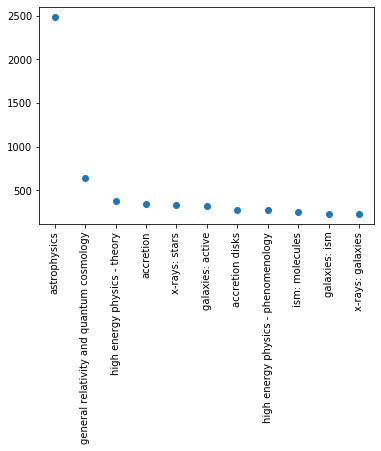

In [3]:
infile = Path("../data/full_04_01_2020/kwds.jsonl")

chunks = pd.read_json(infile, orient='records', lines=True, chunksize=10_000)

df = next(chunks)
vc = df['keyword'].explode().str.lower().value_counts()
plt.plot(vc.index[0:11], vc[0:11], 'o')
plt.xticks(rotation=90)

topics = ['x-ray', 'galax', 'star']

topic_inds = {}
for t in topics:
    b_ind = df[~df['keyword'].isna()]['keyword'].apply(lambda x: sum([True if t in s.lower() else False for s in x]) > 0)
    ind = b_ind.index[b_ind].tolist()
    topic_inds[t] = ind

texts = pd.DataFrame(df['title'] + '. ' + df['abstract']).copy()
texts.columns = ['text']

for t, ind in topic_inds.items():
    texts[t] = np.zeros(texts.shape[0])
    texts.loc[ind, t] = 1

texts = texts[texts.iloc[:, 1:].sum(axis=1) > 0]
texts.shape

In [4]:
hyperparameters = {
    "distance_threshold":2,
    "distance_method": "editdistance",
    "num_keywords" : 10,
    "pair_diff_length":2,
    "stopwords" : STOP_WORDS,
    "bigram_count_threshold":2,
    "num_tokens":[1,2],
    "max_similar" : 3, ## n most similar can show up n times
    "max_occurrence" : 3 ## maximum frequency overall
}

In [5]:
rake_extractor = RAKE.Rake(list(STOP_WORDS))
yake_extractor = yake.KeywordExtractor()
rakun_extractor = RakunDetector(hyperparameters)

01-May-20 09:20:50 - Initiated a keyword detector instance.


In [6]:
fl = '0.5'
th = TextHighlighter(max_ngram_size=3, highlight_pre=f"<span class='my_class' style='background-color:yellow; opacity:{fl}' >", highlight_post="</span>")

In [11]:
# text = """The Ulysses observations have charted the heliosphere around the minimum in the 11 year cycle of solar activity, revealing the large scale properties of the heliospheric medium and its micro-scale characteristics. This book presents for the first time, a comprehensive review of the results of the Ulysses mission.<BR />The first chapter provides an overview of the region, introducing the heliosphere prior to the Ulysses mission, and the objectives and characteristics of the mission itself. Subsequent chapters discuss in detail specific areas of the heliosphere, including the solar wind, large and small scale features, cosmic rays and energetic particles, and the observations of interstellar gas and cosmic dust. Each of these chapters is written by members of the Ulysses science team, concentrating on their own areas of expertise, and is written in a clear and accessible way.<BR />In this book, the authors aim to summarise our understanding of the heliosphere near solar minimum and to provide the basis for understanding the more complex state of the heliosphere around solar maximum, which will be observed during the next phase of the Ulysses mission. <P />"""
# text = """By using the IMAGE magnetometer network data, we compare the geomagnetic variation field B and its time derivative dB/dt in and near the auroral region. We show that although the auroral electrojet is the main reason for large B's, it cannot alone produce large dB/dt's, so smaller-scale current systems are important. This is evidenced by the horizontal field: the geographic north component (X) is clearly larger than the eastward one (Y) in the auroral region, but dX/dt and dY/dt are nearly equal. This result is important when geomagnetic induction risks on man-made conductors are estimated. The key quantity is the horizontal geoelectric field, and contrary to what is often assumed, it can have large values in any direction, not just parallel to the electrojet. <P />"""
# doc = NLP(text)

In [19]:
fs = {
    'rake': lambda x: rake_extractor.run(x, minFrequency=1, minCharacters=3),
#     'yake': lambda x: yake_extractor.extract_keywords(x),
#     'rakun': lambda x: rakun_extractor.find_keywords(x, input_type = "text"),
    'textrank': lambda x: textrank(x, normalize="lemma", topn=999),
}

In [13]:
# rake_kwds = rake_extractor.run(text, minFrequency=1, minCharacters=3)
# yake_kwds = yake_extractor.extract_keywords(text)
# rakun_kwds = rakun_extractor.find_keywords(text, input_type = "text")
# textrank_kwds = textrank(doc, normalize="lemma", topn=999)

In [20]:
tqdm.pandas()

In [21]:
all_kwds = []
for doc in tqdm(NLP.pipe(texts['text'], batch_size=10), total=texts.shape[0]):
    kwds = fs['textrank'](doc)
    all_kwds.append(kwds)
all_kwds_no_vals = [[k[0] for k in kwds] for kwds in all_kwds]
texts['textrank'] = all_kwds_no_vals

In [41]:
# pbar = tqdm(fs.items())
# for s, f in pbar:
#     pbar.set_description(s)
rake_kwds = texts['text'].progress_apply(fs['rake'])
rake_kwds_no_vals = [[k[0] for k in kwds] for kwds in rake_kwds]
texts['rake'] = rake_kwds_no_vals

In [89]:
texts.iloc[]

,text,x-ray,galax,star,textrank,rake
0,A Universal Density Profile from Hierarchical ...,0.0,1.0,0.0,"[halo density profile, equilibrium density pro...","[use high-resolution n-body simulations, step-..."
2,CHIANTI - an atomic database for emission line...,0.0,0.0,1.0,"[CHIANTI atomic database, recent electron exci...","[calculate optically thin synthetic spectra, c..."
3,PEGASE: a UV to NIR spectral evolution model o...,0.0,1.0,0.0,"[NIR spectral evolution model, new spectrophot...","[exceptionally large wavelength range, normali..."
4,A Search for ``Dwarf'' Seyfert Nuclei. III. Sp...,0.0,1.0,0.0,"[luminosity active galactic nucleus, nearby ga...","[low-luminosity active galactic nuclei, stella..."
5,Spectropolarimetric observations of active sta...,0.0,0.0,1.0,"[line T Tauri star V410 Tau, line T Tauri star...","[pre-main-sequence binary hd 155555, new dedic..."
...,...,...,...,...,...,...
9978,Astrometry of the globular cluster 47 Tucanae ...,1.0,1.0,1.0,"[different possible identification, possible o...","[central x-ray sources, x-ray sources found, x..."
9979,A Critical Test of Topological Defect Models: ...,0.0,1.0,0.0,"[inflationary cold dark matter model, texture ...",[non-gaussian topological defect-based cosmolo...
9987,The discovery of very red counterparts to fain...,0.0,1.0,0.0,"[narrow emission line galaxy, UK ROSAT Deep Su...","[present deep k-band imaging, faint x-ray sour..."
9994,The ROSAT bright source RX J0222.4+4729: an ac...,1.0,0.0,1.0,"[emission radial velocity curve, II H+K line e...","[on-line numerical cross-correlation, ii h+k l..."


In [47]:
rake_dct = Dictionary(texts['rake'])

01-May-20 09:33:00 - adding document #0 to Dictionary(0 unique tokens: [])
01-May-20 09:33:01 - built Dictionary(107828 unique tokens: ['allows accurate equilibrium profiles', 'assembled', 'assembly time allows', 'based', 'calculated']...) from 3718 documents (total 229780 corpus positions)


In [48]:
textrank_dct = Dictionary(texts['textrank'])

01-May-20 09:33:11 - adding document #0 to Dictionary(0 unique tokens: [])
01-May-20 09:33:12 - built Dictionary(66221 unique tokens: ['Hierarchical Clustering', 'Press', 'Schechter formalism', 'Universal Density Profile', 'assembly time']...) from 3718 documents (total 160946 corpus positions)


In [50]:
rake_corpus = [rake_dct.doc2bow(t) for t in texts['rake']]
textrank_corpus = [textrank_dct.doc2bow(t) for t in texts['textrank']]

In [64]:
rake_lda = LdaMulticore(rake_corpus, 3, rake_dct)
textrank_lda = LdaMulticore(textrank_corpus, 3, textrank_dct)

01-May-20 09:38:41 - using symmetric alpha at 0.3333333333333333
01-May-20 09:38:41 - using symmetric eta at 0.3333333333333333
01-May-20 09:38:41 - using serial LDA version on this node
01-May-20 09:38:41 - running online LDA training, 3 topics, 1 passes over the supplied corpus of 3718 documents, updating every 22000 documents, evaluating every ~3718 documents, iterating 50x with a convergence threshold of 0.001000
01-May-20 09:38:41 - too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
01-May-20 09:38:41 - training LDA model using 11 processes
01-May-20 09:38:41 - PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/3718, outstanding queue size 1
01-May-20 09:38:41 - PROGRESS: pass 0, dispatched chunk #1 = documents up to #3718/3718, outstanding queue size 2
01-May-20 09:38:45 - topic #0 (0.333): 0.003*"find" + 0.002*"results" + 0.002*"present" + 0.002*"found" + 0.002*"consistent" + 0.002*"galaxies" + 0.00

In [65]:
from gensim.models.coherencemodel import CoherenceModel

In [67]:
rake_cm = CoherenceModel(model=rake_lda, corpus=rake_corpus, coherence='u_mass')
rake_coherence = rake_cm.get_coherence()

01-May-20 09:39:05 - CorpusAccumulator accumulated stats from 1000 documents
01-May-20 09:39:05 - CorpusAccumulator accumulated stats from 2000 documents
01-May-20 09:39:05 - CorpusAccumulator accumulated stats from 3000 documents


In [69]:
textrank_cm = CoherenceModel(model=textrank_lda, corpus=textrank_corpus, coherence='u_mass')
textrank_coherence = textrank_cm.get_coherence()

01-May-20 09:39:17 - CorpusAccumulator accumulated stats from 1000 documents
01-May-20 09:39:17 - CorpusAccumulator accumulated stats from 2000 documents
01-May-20 09:39:17 - CorpusAccumulator accumulated stats from 3000 documents


In [83]:
rake_lda.get_document_topics(rake_corpus[3])

[(2, 0.9893132)]

In [88]:
textrank_lda.get_document_topics(rake_corpus[4])

[(0, 0.7069969), (1, 0.01675347), (2, 0.27624965)]

In [78]:
texts

,text,x-ray,galax,star,textrank,rake
0,A Universal Density Profile from Hierarchical ...,0.0,1.0,0.0,"[halo density profile, equilibrium density pro...","[use high-resolution n-body simulations, step-..."
2,CHIANTI - an atomic database for emission line...,0.0,0.0,1.0,"[CHIANTI atomic database, recent electron exci...","[calculate optically thin synthetic spectra, c..."
3,PEGASE: a UV to NIR spectral evolution model o...,0.0,1.0,0.0,"[NIR spectral evolution model, new spectrophot...","[exceptionally large wavelength range, normali..."
4,A Search for ``Dwarf'' Seyfert Nuclei. III. Sp...,0.0,1.0,0.0,"[luminosity active galactic nucleus, nearby ga...","[low-luminosity active galactic nuclei, stella..."
5,Spectropolarimetric observations of active sta...,0.0,0.0,1.0,"[line T Tauri star V410 Tau, line T Tauri star...","[pre-main-sequence binary hd 155555, new dedic..."
...,...,...,...,...,...,...
9978,Astrometry of the globular cluster 47 Tucanae ...,1.0,1.0,1.0,"[different possible identification, possible o...","[central x-ray sources, x-ray sources found, x..."
9979,A Critical Test of Topological Defect Models: ...,0.0,1.0,0.0,"[inflationary cold dark matter model, texture ...",[non-gaussian topological defect-based cosmolo...
9987,The discovery of very red counterparts to fain...,0.0,1.0,0.0,"[narrow emission line galaxy, UK ROSAT Deep Su...","[present deep k-band imaging, faint x-ray sour..."
9994,The ROSAT bright source RX J0222.4+4729: an ac...,1.0,0.0,1.0,"[emission radial velocity curve, II H+K line e...","[on-line numerical cross-correlation, ii h+k l..."


In [50]:
# rake_kwds_lim = [(k, v) for k, v in rake_kwds if v > -10]
# yake_kwds_lim = [(k, v) for k, v in yake_kwds if v < 99999]
# rakun_kwds_lim = [(k, v) for k, v in yake_kwds if v < 99999]
# textrank_kwds_lim = [(k, v) for k, v in textrank_kwds if v < 99999]

In [51]:
rake_ht = th.highlight(text, rake_kwds_lim)
yake_ht = th.highlight(text, yake_kwds_lim)
rakun_ht = th.highlight(text, rakun_kwds_lim)
textrank_ht = th.highlight(text, textrank_kwds_lim)

In [52]:
vals = np.array([v for k,v in rake_kwds_lim])

In [53]:
tvals = (vals - vals.min()) / (vals.max() - vals.min())

In [54]:
# i = 0
# while True:
#     try:
#         s = rake_ht.index('FILL_VAL')
#     except ValueError:
#         break
#     print(s)
#     rake_ht = rake_ht[:s] + str(tvals[i].round(2)) + rake_ht[s + len(fl):]
#     i += 1

In [55]:
HTML(rake_ht)

In [56]:
HTML(yake_ht)

In [57]:
HTML(rakun_ht)

In [58]:
HTML(textrank_ht)